In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from dataloader import Dataset_from_pkl, is_filled
from model import LSTMTagger, LSTM_hid, LSTM_simple, OneLayer, LSTM_single, LSTM_single_with_emb
torch.manual_seed(1)
from tqdm import tqdm
from utils import compare_prediction_gt


## training on poses
1.37 lstm_tag 
<br>
1.19 lstm_hid
<br>
2.01   lstm_simple
<br>
2.1   OneLayer
<br>
1.8 lstm_single 


In [72]:

def get_observation_other_gt_poses(local_batch, poses=True):
    """
    for each agent in scene generate obseravtion, other_pose, future_poses
    observations -> list[tensors of shape [1,1,20,2]]]
    others -> list[tensors of shape [1,num_others,20,2]]]
    future_poses -> list[tensors of shape [1,1,12,2]]]
    """

    obseravtions = []
    gts = []
    others = []
    
    for ped in range(local_batch.shape[1]):
        observed_pose = local_batch[:, ped, :,2:4]
        obseravtions.append(observed_pose)
        gt_future = local_batch[:, ped:ped+1, 8:, 2:4]
        gts.append(gt_future)
        others_poses = torch.cat((local_batch[:, 0:ped, :, 2:4], local_batch[:, ped+1:, :,2:4]),dim=1)
        others.append(others_poses)

    return obseravtions, gts, others



In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np


def plot_traj(data, ax=None,color="red"):
    
    #data shape [n, 2]
    x_poses = np.zeros((data.shape[0], data.shape[1]))
    y_poses = np.zeros((data.shape[0], data.shape[1]))
    for person in range(data.shape[0]):
        x_poses[person]  = data[person, :, 0].numpy()
        y_poses[person]  = data[person, :, 1].numpy()
    
    for person in range(data.shape[0]):
        if ax is not None:
            ax.plot(x_poses[person], y_poses[person], 'o-', color=color)
        else:
            plt.plot(x_poses[person], y_poses[person], 'o-', color=color)
            plt.show()

In [2]:
training_set = Dataset_from_pkl("/home/robot/repos/trajectories_pred/processed/", data_files=["eth_train.pkl"])
training_generator = torch.utils.data.DataLoader(training_set, batch_size=1)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print (device)
model  = LSTM_hid(10, 2, 2).to(device)
# model  = LSTM_simple(10, 2, 2).to(device)
# model  = OneLayer().to(device)

optimizer = optim.Adam(model.parameters(), lr=0.01)
drop_every_epochs = 5
drop_rate = 0.4
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, drop_every_epochs, drop_rate) # every drop_every_epochs epochs drop by drop_rate lr

loading eth_train.pkl
cuda


### training in separated manner

In [75]:
import time

for epoch in range(0,61):
    epoch_loss = 0
    start = time.time()
    for batch_id, local_batch in enumerate(training_generator):
        if batch_id>100:
            break
        obseravtions, gts, others = get_observation_other_gt_poses(local_batch.to(device))
        batch_loss = 0
        for observation, gt, other in zip(obseravtions, gts, others):
            model.zero_grad()
            fil = is_filled(observation)
            if fil:
                predictions = torch.zeros(1, 1, 0, 2).requires_grad_(True).to(device)
                for timestamp in range(0, 12):
                    
                    prediction = model(observation[:, 0+timestamp:8+timestamp, :], other[:, :, 0+timestamp:8+timestamp, :])
                    predictions = torch.cat((predictions, prediction.unsqueeze(0)), dim=2)

                loss = torch.sum(torch.norm(predictions - gt))
                batch_loss += loss.item()
                loss.backward()
                optimizer.step()
        if len(obseravtions) != 0:
#             print("\tid: {id}, batch_loss: {batch_loss:.2f}".format(batch_loss=batch_loss/len(obseravtions), id=id))
            epoch_loss += batch_loss/len(obseravtions)
        
    print ("epoch {epoch} loss {el:0.4f}, time taken {t:0.2f}".format(epoch=epoch, el=epoch_loss/batch_id,t=time.time()-start) )
    scheduler.step()


epoch 0 loss 2.9254, time taken 21.60
epoch 1 loss 2.1336, time taken 21.45
epoch 2 loss 2.0145, time taken 21.83
epoch 3 loss 1.9000, time taken 21.44
epoch 4 loss 1.8290, time taken 21.44
epoch 5 loss 1.8950, time taken 21.49
epoch 6 loss 1.7283, time taken 21.51
epoch 7 loss 1.6438, time taken 21.30
epoch 8 loss 1.5493, time taken 21.49
epoch 9 loss 1.5060, time taken 21.53
epoch 10 loss 1.5299, time taken 21.46
epoch 11 loss 1.4339, time taken 21.45
epoch 12 loss 1.4058, time taken 21.36
epoch 13 loss 1.3981, time taken 21.45
epoch 14 loss 1.3729, time taken 21.58
epoch 15 loss 1.3940, time taken 21.43
epoch 16 loss 1.3475, time taken 21.54
epoch 17 loss 1.3333, time taken 21.46
epoch 18 loss 1.3257, time taken 21.47
epoch 19 loss 1.3169, time taken 21.51
epoch 20 loss 1.3144, time taken 21.50
epoch 21 loss 1.3063, time taken 21.40
epoch 22 loss 1.2994, time taken 21.48
epoch 23 loss 1.2954, time taken 21.55
epoch 24 loss 1.2922, time taken 21.61
epoch 25 loss 1.2895, time taken 21

torch.Size([1, 1, 12, 2])


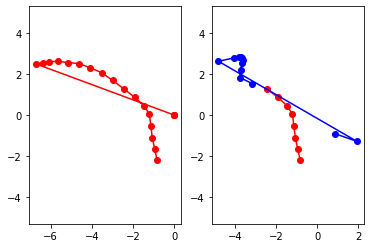

In [108]:
for batch_id, local_batch in enumerate(training_generator):
    if batch_id != 180:
        continue
    obseravtions, gts, others = get_observation_other_gt_poses(local_batch.to(device))
    
    for observation, gt, other in zip(obseravtions, gts, others):
        gt = observation.clone()
        predictions = torch.zeros(1, 1, 0, 2).requires_grad_(True).to(device)
        for timestamp in range(0, 12):
            prediction = model(observation[:, 0+timestamp:8+timestamp, :].clone(), other[:, :, 0+timestamp:8+timestamp, :].clone())
            observation[:,9+t:10+t,:] = prediction.clone()
            predictions = torch.cat((predictions, prediction.unsqueeze(0)), dim=2)
        break
    break
pass


data = gt[:,:,:].detach().cpu()

f, ax = plt.subplots(1,2)
plot_traj(data,ax[0])

data = gt[:,0:8,:].detach().cpu()
plot_traj(data,ax[1])
plot_traj(predictions[0].detach().cpu(),ax[1], color="b")

ax[0].axis('equal')
ax[1].axis('equal')
ax[0].set_ylim(-7, 7)
ax[1].set_ylim(-7, 7)

print (predictions.shape)

# data = torch.cat((data, predictions[0].detach().cpu()), dim=1)
# plot_traj(data)

# Parallel manner

###  single - 1.83
###  single with emb- 1.57 (LSTM_single_with_emb(40, 20, 2))

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from dataloader import Dataset_from_pkl, is_filled
from model import LSTMTagger, LSTM_hid, LSTM_simple, OneLayer, LSTM_single, LSTM_single_with_emb, LSTM_delta
torch.manual_seed(1)
from tqdm import tqdm
from utils import compare_prediction_gt


In [2]:
from torch.utils.tensorboard import SummaryWriter

def setup_experiment(title, logdir="./tb"):
    experiment_name = "{}@{}".format(title, datetime.now().strftime("%d.%m.%Y-%H:%M:%S"))
    writer = SummaryWriter(log_dir=os.path.join(logdir, experiment_name))
    best_model_path = f"{title}.best.pth"
    return writer, experiment_name, best_model_path


def get_ade_fde(generator, model, limit=1e10):
    ade = []
    fde = []
    for batch_id, local_batch in enumerate(generator):

        if batch_id > limit:
            break
        if local_batch.shape[1] < 1:
            continue
        gt = local_batch.clone()
        local_batch = local_batch.to(device)
        num_peds = local_batch.shape[1]
        predictions = torch.zeros(num_peds, 0, 2).requires_grad_(True).to(device)

        for t in range(0, 12):
            prediction = model(local_batch[0, :, 0 + t: 8 + t, 2:4])

            #                 prediction = prediction.unsqueeze(1)
            predictions = torch.cat((predictions, prediction), dim=1)
            local_batch[0, :, 8 + t:9 + t, 2:4] = prediction.detach()

        metrics = compare_prediction_gt(predictions.detach().cpu(), gt.detach().cpu()[0][:, :, 2:4])

        for local_ade in metrics["ade"]:
            ade.append(local_ade)
        for local_fde in metrics["fde"]:
            fde.append(local_fde)
    ade = sum(ade) / len(ade)
    fde = sum(fde) / len(fde)
    return (ade, fde)


def get_batch_is_filled_mask(batch):
    num_peds = batch.shape[1]
    mask = torch.zeros(num_peds, 12, 2)
    full_peds = 0
    for ped in range(num_peds):
        if is_filled(batch[0][ped]):
            mask[ped] = torch.ones(12, 2)
            full_peds+=1
    return mask, max(full_peds,1)

def get_is_filled_mask(batch):
    num_peds = batch.shape[1]
    mask = torch.zeros(batch.shape[0], num_peds, 12, 2)
    for b in range(batch.shape[0]):
        submask = get_batch_is_filled_mask(batch[b:b+1])
        mask[b, ...] = submask[0]
    return  mask
    

In [3]:
training_set = Dataset_from_pkl("/home/robot/repos/trajectory-prediction/processed/", data_files=["eth_train.pkl"])
training_generator = torch.utils.data.DataLoader(training_set, batch_size=1)

test_set = Dataset_from_pkl("/home/robot/repos/trajectory-prediction/processed/", data_files=["eth_test.pkl"])
test_generator = torch.utils.data.DataLoader(training_set, batch_size=1)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print (device)
# model  = LSTM_single(20, 2, 2).to(device)
# model  = LSTM_simple(10, 2, 2).to(device)

# model = LSTM_single_with_emb(40, 20, 2).to(device)
model = LSTM_delta(40, 20, 2).to(device)



loading eth_train.pkl
loading eth_test.pkl
cuda


In [4]:
import time
from datetime import datetime
import os
optimizer = optim.Adam(model.parameters(), lr=0.01)
drop_every_epochs = 10
drop_rate = 0.4
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, drop_every_epochs, drop_rate) # every drop_every_epochs epochs drop by drop_rate lr
writer, _, _ = setup_experiment("LSTM_single_with_emb")



In [10]:
batch_size  = 5
batch_id = 0
dataset_len = len(training_set)

while batch_id < dataset_len:
    local_batch = training_set[batch_id, batch_size]
    batch_id += batch_size
    mask = get_is_filled_mask(local_batch)
    local_batch = local_batch.to(device)
    print (local_batch.shape)
    model(local_batch)
#     for batch in range (0, batch_size):
        
#         mask, _ = get_batch_is_filled_mask(local_batch[batch:batch+1])
    break


# for batch_id, local_batch in enumerate(training_set[batch_id, batch_size]):
#     batch_id+=batch_size
#     print (local_batch.shape)
#     break
    # for batch_id, local_batch in enumerate(training_generator):
#     if batch_id != 120:
#         continue
#     mask, _ = get_batch_is_filled_mask(local_batch)
#     print (mask[:,0,0])
#     break


torch.Size([5, 4, 20, 8])


RuntimeError: size mismatch, m1: [400 x 8], m2: [2 x 20] at /opt/conda/conda-bld/pytorch_1587428094786/work/aten/src/THC/generic/THCTensorMathBlas.cu:283

In [8]:
prev_epoch_loss = 0
for epoch in range(0,61):
    model.train()
    epoch_loss = 0
    start = time.time()
    epoch_loss = 0
    num_skipped = 0
    for batch_id, local_batch in enumerate(training_generator):
        if (batch_id>100):
            break
        local_batch = local_batch.to(device)
        model.zero_grad()
        num_peds = local_batch.shape[1]
        predictions = torch.zeros(num_peds, 0, 2).requires_grad_(True).to(device)
        mask, full_peds = get_batch_is_filled_mask(local_batch)
        mask = mask.to(device)
        gt = local_batch.clone()
        if torch.sum(mask) == 0.0:
            num_skipped += 1
            continue
        for t in range(0, 12):
            prediction = model(local_batch[0,:,0+t:8+t,2:4])
            predictions = torch.cat((predictions, prediction), dim=1)

        loss = torch.sum(torch.norm(mask*(predictions - gt[0,:,8:,2:4])))
        epoch_loss += loss.item()/full_peds
        loss.backward()
        optimizer.step()
    
    epoch_loss = epoch_loss/(batch_id - num_skipped)
    print ("epoch {epoch} loss {el:0.4f}, time taken {t:0.2f}, delta {delta:0.3f}".format(epoch=epoch, el=epoch_loss,t=time.time()-start, delta=-prev_epoch_loss+epoch_loss) )
    if writer is not None:
            writer.add_scalar(f"loss_epoch", epoch_loss, epoch)

    prev_epoch_loss = epoch_loss
    scheduler.step()
    model.eval()
    ade, fde = get_ade_fde(test_generator, model,50)
    if writer is not None:
            writer.add_scalar(f"ade", ade, epoch)
            writer.add_scalar(f"fde", fde, epoch)

epoch 0 loss 1.2896, time taken 3.40, delta 1.290
epoch 1 loss 1.0313, time taken 3.34, delta -0.258


KeyboardInterrupt: 

In [13]:
for batch_id, local_batch in enumerate(training_generator):
    if batch_id != 400:
        continue
    gt = local_batch.clone()
    local_batch = local_batch.to(device)
    num_peds = local_batch.shape[1]
    predictions = torch.zeros(num_peds, 0, 2).requires_grad_(True).to(device)
    
    for t in range(0,12):
#             print (local_batch[0,3,7+t:10+t,2:4])
            prediction = model(local_batch[0,:,0+t:8+t,2:4])
#             print (prediction[3,:])
            prediction = prediction.unsqueeze(1)
            predictions = torch.cat((predictions, prediction), dim=1)
            local_batch[0,:,9+t:10+t,2:4] = prediction.detach()
#             print (local_batch[0,3,9+t,2:4])
        
    break
pass

ped_num = 1

data = gt[0,ped_num:ped_num+1,:,2:4].cpu()

fig, ax = plt.subplots(1, 3, figsize=(9, 3))
plot_traj(data, ax=ax[1],color="blue")

data = gt[0,:,:,2:4].cpu()
plot_traj(data, ax=ax[0],color="blue")

# data = torch.cat((gt[0,ped_num:ped_num+1,0:8,2:4], predictions[ped_num:ped_num+1,:,:].detach().cpu()),dim=1)\

plot_traj(gt[0,ped_num:ped_num+1,0:8,2:4], ax[2], color="blue")
plot_traj(predictions[ped_num:ped_num+1, :, :].detach().cpu(),ax[2])

ax[0].axis('equal')
ax[1].axis('equal')
ax[2].axis('equal')

ax[0].set_ylim(-10, 10)
ax[0].set_xlim(-10, 10)

ax[1].set_ylim(-10, 10)
ax[1].set_xlim(-10, 10)


# data = obseravtions[0][:,:,:].detach().cpu()
# plot_traj(data)
# data = obseravtions[0][:,0:8,:].detach().cpu()
# data = torch.cat((data, predictions[0].detach().cpu()), dim=1)
# plot_traj(data)

RuntimeError: Tensors must have same number of dimensions: got 4 and 3

In [12]:
get_ade_fde(training_generator, model, 200)

RuntimeError: size mismatch, m1: [6 x 8], m2: [2 x 20] at /opt/conda/conda-bld/pytorch_1587428094786/work/aten/src/THC/generic/THCTensorMathBlas.cu:283

In [17]:
import math
sum([1,2,3,4])/len([1,2,3,4])

2.5

In [3]:
for batch_id, local_batch in enumerate(training_generator):
    if batch_id != 180:
        continue
    print(local_batch[0][0])

tensor([[ 3.2000e+01,  1.8000e+02, -8.3340e-01, -2.1798e+00, -2.9465e-01,
          1.3365e+00,  7.5636e-03,  5.2207e-03],
        [ 3.2000e+01,  1.8100e+02, -9.5127e-01, -1.6452e+00, -2.8860e-01,
          1.3407e+00,  8.1884e-02,  5.7800e-02],
        [ 3.2000e+01,  1.8200e+02, -1.0643e+00, -1.1072e+00, -2.2914e-01,
          1.3827e+00,  1.4141e-01,  9.9939e-02],
        [ 3.2000e+01,  1.8300e+02, -1.1346e+00, -5.3900e-01, -1.7548e-01,
          1.4206e+00, -2.0257e-01, -2.0957e-01],
        [ 3.2000e+01,  1.8400e+02, -1.2047e+00,  2.9251e-02, -3.9120e-01,
          1.2151e+00, -8.8790e-01, -4.7695e-01],
        [ 3.2000e+01,  1.8500e+02, -1.4475e+00,  4.3306e-01, -8.8580e-01,
          1.0391e+00, -1.0918e+00, -1.9279e-01],
        [ 3.2000e+01,  1.8600e+02, -1.9133e+00,  8.6050e-01, -1.2646e+00,
          1.0608e+00, -5.7516e-01, -8.5768e-03],
        [ 3.2000e+01,  1.8700e+02, -2.4592e+00,  1.2817e+00, -1.3459e+00,
          1.0322e+00, -8.2871e-02, -1.1336e-01],
        [ 3.2000

In [7]:
a = torch.ones(2,20,2)
b = 1 * torch.ones(2,12,2)
compare_prediction_gt(b,a)

{'id': [0, 1], 'ade': [0.0, 0.0], 'fde': [0.0, 0.0], 'kde': [nan, nan]}

In [11]:
t = torch.rand(1,20,1)
print (t)
print (t[:,8,:])
print (t[:,8:9,:])


tensor([[[0.2365],
         [0.0697],
         [0.8606],
         [0.2252],
         [0.6933],
         [0.6357],
         [0.9539],
         [0.3389],
         [0.8169],
         [0.0401],
         [0.3992],
         [0.5462],
         [0.8933],
         [0.0872],
         [0.7167],
         [0.3907],
         [0.1165],
         [0.4998],
         [0.9373],
         [0.2618]]])
tensor([[0.8169]])
tensor([[[0.8169]]])
